#### Apr. 16, 2019
Generate mutation frequencies from output.gd files. Functions adapted from ```tidy_breseq.py``` and ```plot_polymorphisms.py```.

In [27]:
import numpy as np
import pandas as pd
import re
import glob

In [28]:
def subset_outputgd_to_df(gdfile, sample_name, line, generation=np.nan, cov=False):
    '''
    Default returns one dataframe created from annotated.gd. All mutation rows are preserved,
    but only selected variables from each row, namely entry type, entry id, 
    evidence id, genome id, position, mutation detail, frequency, and gene product.
    
    If cov=True, will return TWO dataframes, the first as above, the second reporting 
    entry type, entry id, evidence id, genome id, position,reject reasons, prediction mode, 
    polymorphism frequencies, major and minor coverages (i.e., major_cov, minor_cov), 
    total coverage (total_cov), RA coverage (new_cov), JC coverage (new_junction_read_count), 
    and MC-flanking coverage (left_outside_cov + right_outside_cov).
    '''
    df = pd.read_csv(gdfile, comment='#', names=range(200), dtype=str, sep='\t')
    df = df.dropna(axis=1, how='all')
    # https://stackoverflow.com/questions/27700591/reading-csv-files-with-messy-structure-with-pandas
    df.rename(columns = {0: 'entry_type', 1: 'entry_id', 2: 'evidence_id', 
                         3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)

    df_mutations = df[(df['entry_type'] == 'INS') | (df['entry_type'] == 'DEL') | 
                      (df['entry_type'] == 'SNP') | (df['entry_type'] == 'SUB') | 
                      (df['entry_type'] == 'MOB') | (df['entry_type'] == 'AMP') | 
                      (df['entry_type'] == 'CON') | (df['entry_type'] == 'INV')].copy()
    df_mutations = df_mutations.dropna(axis=1, how='all')
    num_columns = len(df_mutations.columns)

    for row in df_mutations.index:
        #check each column
        mut_col_index = 6
        while mut_col_index < num_columns:
            #1. mutation frequencies
            if re.match('frequency=', str(df_mutations.loc[row, mut_col_index])):
                df_mutations.loc[row, 'frequency'] = re.sub('frequency=', '', str(df_mutations.loc[row, mut_col_index]))
                if df_mutations.loc[row, 'frequency'] == 'NA':
                    df_mutations.loc[row, 'frequency'] = np.nan
            mut_col_index += 1

    df_mutations = df_mutations[['entry_type', 'entry_id', 'evidence_id', 'genome_id', 
                             'position', 'mutation_detail', 'frequency']].copy()
    
    #insert sample name, line, and generation
    df_mutations.insert(0, 'sample', sample_name)
    df_mutations.insert(1, 'line', line)
    df_mutations.insert(2, 'generation', generation)
    #set frequencies type to float
    df_mutations['frequency'] = df_mutations['frequency'].astype(float)

    if cov == True:
        df_evidence = df[(df['entry_type'] == 'RA') | (df['entry_type'] == 'JC') | 
                         (df['entry_type'] == 'MC') | (df['entry_type'] == 'UN')].copy()
        df_evidence.rename(columns = {6: 'REF', 7: 'ALT'}, inplace=True)

        for row in df_evidence.index:
            col_index = 8
            while col_index < num_columns:
                #3. polymorphism rejection reasons
                if re.match('reject=', str(df_evidence.loc[row, col_index])):
                    df_evidence.loc[row, 'reject'] = re.sub('reject=', '', str(df_evidence.loc[row, col_index]))
                #4. prediction type
                elif re.match('prediction=', str(df_evidence.loc[row, col_index])):
                    df_evidence.loc[row, 'prediction'] = re.sub('prediction=', '', str(df_evidence.loc[row, col_index]))
                #5. polymorphism mode frequencies
                elif re.match('polymorphism_frequency=', str(df_evidence.loc[row, col_index])):
                    df_evidence.loc[row, 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df_evidence.loc[row, col_index]))
                    if df_evidence.loc[row, 'polymorphism_frequency'] == 'NA':
                        df_evidence.loc[row, 'polymorphism_frequency'] = np.nan
                #6. major coverage counts
                elif re.match('major_cov=', str(df_evidence.loc[row, col_index])):
                    major_cov = re.sub('major_cov=', '', str(df_evidence.loc[row, col_index]))
                    df_evidence.loc[row, 'major_cov'] = sum_cov(major_cov)
                #7. minor coverage counts
                elif re.match('minor_cov', str(df_evidence.loc[row, col_index])):
                    minor_cov = re.sub('minor_cov=', '', str(df_evidence.loc[row, col_index]))
                    df_evidence.loc[row, 'minor_cov'] = sum_cov(minor_cov)
                #8. total coverage counts
                elif re.match('total_cov=', str(df_evidence.loc[row, col_index])):
                    total_cov = re.sub('total_cov=', '', str(df_evidence.loc[row, col_index]))
                    df_evidence.loc[row, 'total_cov'] = sum_cov(total_cov)
                #9. read alignment coverage counts
                elif re.match('new_cov=', str(df_evidence.loc[row, col_index])):
                    ra_cov = re.sub('new_cov=', '', str(df_evidence.loc[row, col_index]))
                    df_evidence.loc[row, 'ra_cov'] = sum_cov(ra_cov)
                #10. new junction coverage counts
                elif re.match('new_junction_read_count=', str(df_evidence.loc[row, col_index])):
                    df_evidence.loc[row, 'jc_cov'] = re.sub('new_junction_read_count=', '', str(df_evidence.loc[row, col_index]))
                #11. flanking coverage counts for missing coverage evidence
                elif re.match('left_outside_cov=', str(df_evidence.loc[row, col_index])):
                    left_cov = re.sub('left_outside_cov=', '', str(df_evidence.loc[row, col_index]))
                    if left_cov == 'NA':
                        left_cov = 0
                    else:
                        df_evidence.loc[row, 'left_cov'] = int(left_cov)
                elif re.match('right_outside_cov', str(df_evidence.loc[row, col_index])):
                    right_cov = re.sub('right_outside_cov=', '', str(df_evidence.loc[row, col_index]))
                    if right_cov == 'NA':
                        right_cov = 0
                    else:
                        df_evidence.loc[row, 'right_cov'] = int(right_cov)
                col_index += 1
        
        #set missing coverage col to 'NA' if no evidence
        if 'left_cov' in df_evidence.columns and 'right_cov' in df_evidence.columns:
            df_evidence[['left_cov', 'right_cov']].fillna(0)
            df_evidence['mc_cov'] = df_evidence.left_cov + df_evidence.right_cov
        else:
            df_evidence['mc_cov'] = np.nan        
        #set reject col to 'NA' when no reject reason given.
        if 'reject' in df_evidence.columns:
            if (df_evidence.loc[row, 'reject'] == '') & (df_evidence.loc[row, 'evidence_id'] == '.'):
                df_evidence.loc[row, 'reject'] = np.nan
        else:
            df_evidence['reject'] = np.nan
        
        df_evidence = df_evidence[['entry_type', 'entry_id', 'genome_id', 'position', 'REF', 'ALT',
                     'reject', 'prediction', 'polymorphism_frequency', 'major_cov', 'minor_cov', 
                     'total_cov', 'ra_cov', 'jc_cov', 'mc_cov']].copy()
        
        #insert sample name, line and generation
        df_evidence.insert(0, 'sample', sample_name)
        df_evidence.insert(1, 'line', line)
        df_evidence.insert(2, 'generation', generation)
        #set frequencies type to float
        df_evidence['polymorphism_frequency'] = df_evidence['polymorphism_frequency'].astype(float)
        
        return df_mutations, df_evidence

    else:
        return df_mutations

In [71]:
input_directory = '/Users/ymseah/Documents/gdiff_files/'
output_directory = '/Users/ymseah/Repositories/dataviz/viz/20190416/'

ancestor_df = subset_outputgd_to_df(input_directory + '0.gd', 'Ancestor', 'Ancestor', 0)

#Corrected sample swap as of 4/16/19
samples_dict = {'UA3': ['U1-100', 'UA3-300', 'U1-500', 'UE3-780', 'UE3-1000'],
                'UE3': ['U2-100', 'UE3-300', 'U2-500', 'UA3-780', 'UA3-1000'],
                'UR1': ['U5-100', 'UR1-300', 'U5-500', 'UR1-780', 'UR1-1000'],
                'US1': ['U6-100', 'US1-300', 'U6-500', 'US1-780', 'US1-1000'],
                'HA3': ['H1-100', 'HA3-300', 'H1-500', 'HA3-780', 'HA3-1000'],
                'HE3': ['H2-100', 'HE3-300', 'H2-500', 'HE3-780', 'HE3-1000'],
                'HR2': ['H5-100', 'HR2-300', 'H5-500', 'HR2-780', 'HR2-1000'],
                'HS3': ['H6-100', 'HS3-300', 'H6-500', 'HS3-780', 'HS3-1000']}

In [72]:
import matplotlib.pyplot as plt

for line in samples_dict.keys():
    all_dfs = [ancestor_df]
    for sample in samples_dict[line]:
        df = subset_outputgd_to_df(input_directory + sample + '.gd', sample, line, int(sample.split('-')[1]))
        all_dfs.append(df)
    final_df = pd.concat(all_dfs, ignore_index=True)
    final_df['polymorphism'] = final_df['position'].astype(str).str.cat(final_df['entry_type'], sep=' ').str.cat(final_df['mutation_detail'], sep=' ')
    df_pvt = final_df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='frequency')
    
    #plot DvH
    dvh_df = df_pvt.loc['NC_002937'].dropna(axis=1, how='all').fillna(0)
    for col in dvh_df.columns:
        if list(dvh_df[col]) == len(dvh_df[col])*[1.0]:
            dvh_df = dvh_df.drop(col, axis=1)
    dvh_df.plot(figsize = (20,15), legend=False, title='NC_002937: DvH Polymorphism Frequencies')
    plt.savefig(output_directory + line + 'dvhcorrected.png')
    plt.close()
    
    #plot Mm
    mm_df = df_pvt.loc['NC_005791'].dropna(axis=1, how='all').fillna(0)
    for col in mm_df.columns:
        if list(mm_df[col]) == len(mm_df[col])*[1.0]:
            mm_df = mm_df.drop(col, axis=1)
    mm_df.plot(figsize = (20,15), legend=False, title='NC_005791: Mm Polymorphism Frequencies')
    plt.savefig(output_directory + line + 'mmcorrected.png')
    plt.close()
    
    #plot Dv Plasmid
    dvplasmid_df = df_pvt.loc['NC_005863'].dropna(axis=1, how='all').fillna(0)
    for col in dvplasmid_df.columns:
        if list(dvplasmid_df[col]) == len(dvplasmid_df[col])*[1.0]:
            dvplasmid_df = dvplasmid_df.drop(col, axis=1)
    
    dvplasmid_df.plot(figsize = (20,15), legend=False, title='NC_005863: DvH Plasmid Polymorphism Frequencies')
    plt.savefig(output_directory + line + 'dvplasmidcorrected.png')
    plt.close()

In [62]:
#For 
samples = ['U1-100', 'UA3-300', 'U1-500', 'UE3-780', 'UE3-1000']

ancestor_df = subset_outputgd_to_df(input_directory + '0.gd', 'Ancestor', 'Ancestor', 0)
all_dfs = [ancestor_df]

for each in samples:
    df = subset_outputgd_to_df(input_directory + each + '.gd', each, 'UA3', int(each.split('-')[1]))
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)

In [63]:
final_df['polymorphism'] = final_df['position'].astype(str).str.cat(final_df['entry_type'], sep=' ').str.cat(final_df['mutation_detail'], sep=' ')
df = final_df[['line', 'genome_id', 'generation', 'polymorphism', 'frequency']].copy()
df_pvt = df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='frequency')

In [64]:
dvh_df = df_pvt.loc['NC_002937'].dropna(axis=1, how='all').fillna(0)
mm_df = df_pvt.loc['NC_005791'].dropna(axis=1, how='all').fillna(0)
dvplasmid_df = df_pvt.loc['NC_005863'].dropna(axis=1, how='all').fillna(0)

In [65]:
for col in dvh_df.columns:
    if list(dvh_df[col]) == len(dvh_df[col])*[1.0]:
        dvh_df = dvh_df.drop(col, axis=1)

In [ ]:
for col in mm_df.columns:
    if list(mm_df[col]) == len(dvh_df[col])*[1.0]:
        mm_df = mm_df.drop(col, axis=1)

In [ ]:
for col in dvplasmid_df.columns:
    if list(dvplasmid_df[col]) == len(dvh_df[col])*[1.0]:
        dvplasmid_df = dvplasmid_df.drop(col, axis=1)

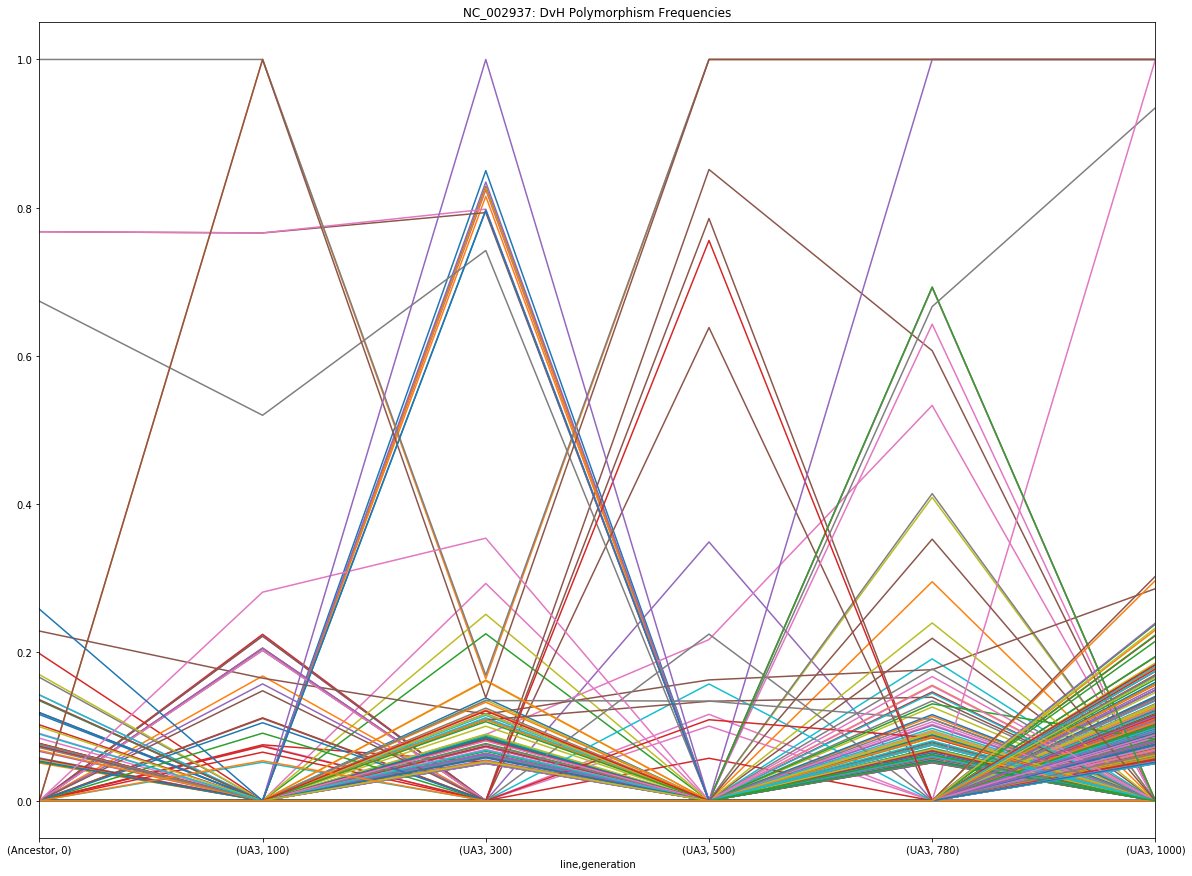

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
dvh_df.plot(figsize = (20,15), legend=False, title='NC_002937: DvH Polymorphism Frequencies')
plt.savefig('/Users/ymseah/Repositories/dataviz/viz/ua3dvhcorrected.png')

In [ ]:
mm_df.plot(figsize = (20,15), legend=False, title='NC_005791: Mm Polymorphism Frequencies')
plt.savefig('/Users/ymseah/Repositories/dataviz/viz/ua3mmcorrected.png')

In [ ]:
dvplasmid_df.plot(figsize = (20,15), legend=False, title='NC_005863: DvH Plasmid Polymorphism Frequencies')
plt.savefig('/Users/ymseah/Repositories/dataviz/viz/ua3dvplasmidcorrected.png')

#### Sept. 22, 2017

Generate input csv files (from breseq output of annotated.gd) for plotting with the following code snippets from ```lost_polymorphisms.py``` and ```plot_polymorphisms.py```.

In [ ]:
## Script from plot_polymorphisms.py

from lost_polymorphisms import ComparePolymorphisms

input_directory = '~/Documents/gdiff_files/'
output_directory = '~/Repositories/dataviz/data/'
ancestor_gd_path = input_directory + '0.gd'
evolution_lines = ['HA3', 'HE3', 'HR2', 'HS3', 'UA3', 'UE3', 'UR1', 'US1']

cp_gd = ComparePolymorphisms()
for line in evolution_lines:
    line_df = cp_gd.get_all_gd(line, input_directory, ancestor_gd_path)
    output_csv = output_directory + line + '_gd_freqs.csv'
    frequencies_df = cp_gd.gd_frequencies_to_df(line_df, save_csv=True, csv_filename=output_csv)


In [ ]:
## Two relevant functions from class ComparePolymorphisms, in lost_polymorphisms.py

def get_all_gd(self, evolution_line, input_directory, path_to_ancestor_gd):
    '''
    Input1: name of evolution line
    Input2: directory path to all breseq results
    Input3: path to GenomeDiff file for ancestral (generation 0) population.
    Output: GD files for all generations of the evolution line, concatenated as one data frame.
    '''
    ancestor_df = self.annotated_gd_to_df(path_to_ancestor_gd, 0)
    annotated_gd_files = glob.glob(input_directory + '*' + evolution_line + '*/output/*.gd')
    print(annotated_gd_files)
    all_dataframes = [ancestor_df]
    for genome_diff in annotated_gd_files:
        generation = int(genome_diff[-8:-3].split('-')[1])
        dataframe = self.annotated_gd_to_df(genome_diff, generation)
        all_dataframes.append(dataframe)
    evolution_line_dataframe = pd.concat(all_dataframes, ignore_index=True)
    evolution_line_dataframe.insert(0, 'line', evolution_line)
    return evolution_line_dataframe

def gd_frequencies_to_df(self, df_from_all_gd, save_csv=False, csv_filename='gd_freqs.csv'):
    '''
    Input: output from get_all_gd(), i.e., data frame of combined gd files from one evolution line.
    Output: data frame of all polymorphisms with frequencies, for plotting.
    '''
    df_from_all_gd.insert(2, 'consensus_frequency', 'NaN')
    df_from_all_gd.insert(3, 'polymorphism_frequency', 0.0)
    df_from_all_gd.rename(columns = {0: 'entry_type', 1: 'item_id', 2: 'evidence_id', 3: 'genome_id', 4: 'position', 5: 'mutation_detail'}, inplace=True)
    # entry types obtained from http://barricklab.org/twiki/pub/Lab/ToolsBacterialGenomeResequencing/documentation/gd_format.html
    df_polymorphisms = df_from_all_gd[(df_from_all_gd['entry_type'] == 'INS') | (df_from_all_gd['entry_type'] == 'DEL') | 
            (df_from_all_gd['entry_type'] == 'SNP') | (df_from_all_gd['entry_type'] == 'SUB') | (df_from_all_gd['entry_type'] == 'MOB') | 
            (df_from_all_gd['entry_type'] == 'AMP') | (df_from_all_gd['entry_type'] == 'CON') | (df_from_all_gd['entry_type'] == 'INV')].copy()
    for row in df_polymorphisms.itertuples():
        for col_index in range(6, 51):
            if re.match('frequency', str(df_polymorphisms.loc[row[0], col_index])):
                df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('frequency=', '', str(df_polymorphisms.loc[row[0], col_index]))
                if df_polymorphisms.loc[row[0], 'polymorphism_frequency'] == '1':
                    df_polymorphisms.loc[row[0], 'consensus_frequency'] = 1.0
                    evidence_id = df_polymorphisms.loc[row[0], 'evidence_id']
                    evidence_row = df_from_all_gd[df_from_all_gd['item_id'] == evidence_id].index
                    for evidence_col in range(6, 51):
                        if re.match('polymorphism_frequency', str(df_from_all_gd.loc[evidence_row, evidence_col])):
                            df_polymorphisms.loc[row[0], 'polymorphism_frequency'] = re.sub('polymorphism_frequency=', '', str(df_from_all_gd.loc[evidence_row, evidence_col]))
                        break
            break
                
    df_polymorphisms_for_plotting = df_polymorphisms[['line', 'generation', 'entry_type', 'item_id', 'mutation_detail',  
                                                      'genome_id', 'position', 'polymorphism_frequency', 'consensus_frequency']].copy()
    dtype = {'line': str, 'generation': int, 'entry_type': str, 'item_id': str, 'genome_id': str,
             'position': str, 'polymorphism_frequency': float, 'consensus_frequency': float}
    for key, value in dtype.items():
        df_polymorphisms_for_plotting[key] = df_polymorphisms_for_plotting[key].astype(value)
    if save_csv == True:
        df_polymorphisms_for_plotting.to_csv(csv_filename, index=False)
    
    return df_polymorphisms_for_plotting

In [ ]:
# one evolution line only
csv = '/Users/ymseah/Repositories/dataviz_scripts/sUA3_gd_freqs.csv'
df = pd.read_csv(csv)
df['polymorphism'] = df['position'].astype(str).str.cat(df['entry_type'], sep=' ').str.cat(df['mutation_detail'], sep=' ')
df = df[['line', 'genome_id', 'generation', 'polymorphism', 'polymorphism_frequency']].copy()
df_pvt = df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='polymorphism_frequency')

In [ ]:
all_csv = glob.glob('/Users/ymseah/Repositories/dataviz/data/*_gd_freqs.csv')
df_list = []
for csv in all_csv:
    df = pd.read_csv(csv)
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)
all_df['polymorphism'] = all_df['position'].astype(str).str.cat(all_df['entry_type'], sep=' ').str.cat(all_df['mutation_detail'], sep=' ')
all_df = all_df[['line', 'genome_id', 'generation', 'polymorphism', 'polymorphism_frequency']].copy()
all_df_pvt = all_df.pivot_table(index=['genome_id', 'line', 'generation'], columns='polymorphism', values='polymorphism_frequency')

In [ ]:
pivoted = df_pvt
dvh_df = pivoted.loc['NC_002937'].dropna(axis=1, how='all')
mm_df = pivoted.loc['NC_005791'].dropna(axis=1, how='all')
dvplasmid_df = pivoted.loc['NC_005863'].dropna(axis=1, how='all')

In [ ]:
pivoted

In [ ]:
def fluctuating_bools(df):
    '''
    Returns 2 lists of alternating bool values. Default list length is the number of indexes in df.
    '''
    true_false = []
    false_true = []
    count = 0
    while count < len(df.index.tolist()):
        true_false.append(True)
        false_true.append(False)
        count += 1
        if count < len(df.index.tolist()):
            true_false.append(False)
            false_true.append(True)
            count += 1
    return true_false, false_true

def greater_than_last_gen(df):
    '''Compares if frequencies in each row greater than in previous row, 
    returns df of bool values'''
    comparisons = {}
    count = 0
    while count < len(df.index)-1:
        comparisons[str(count+1) + '_to_' + str(count)] = df.loc[df.index[count+1]] > df.loc[df.index[count]]
        count += 1
    compare_df = pd.DataFrame(comparisons).T
    return compare_df

def subset_fluctuating_frequencies(df):
    '''Returns list of df columns with fluctuating polymorphisms'''
    t_f, f_t = fluctuating_bools(df)
    fluctuating_polymorphisms = []
    for col in df.columns:
        if (df[col].tolist() == t_f) | (df[col].tolist() == f_t):
            fluctuating_polymorphisms.append(col)
    return fluctuating_polymorphisms

def subset_some_fluctuation(df, tf_len=3):
    t_f, f_t = fluctuating_bools(df)
    some_t_f = t_f[:tf_len]
    some_f_t = f_t[:tf_len]
    some_flux = []
    for col in df.columns:
        bools_list = df[col].tolist()
        count = 0
        while count <= (len(bools_list)-3):
            bools_slice = bools_list[count:(count+3)]
            if (bools_slice == some_t_f) | (bools_slice == some_f_t):
                some_flux.append(col)
            count += 1
    return list(set(some_flux))

def subset_monotonic(df):
    '''
    Returns 2 lists of column names that have monotonically increasing, and decreasing values. 
    '''
    mono_inc = []
    mono_dec = []
    for col in df.columns:
        if df[col].is_monotonic_increasing:
            mono_inc.append(col)
        elif df[col].is_monotonic_decreasing:
            mono_dec.append(col)
    return mono_inc, mono_dec

# Plotting functions

def plot_fluctuating(df, some_flux=False, flux_len=3):
    compare_freqs = greater_than_last_gen(df)
    if some_flux == False:
        flux = subset_fluctuating_frequencies(compare_freqs)
    else:
        flux = subset_some_fluctuation(compare_freqs, tf_len = flux_len)
    df[flux].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)   

def plot_line_summary(line, df, plottitle):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    # monotonic
    inc, dec = subset_monotonic(data)
    fig, axes = plt.subplots(5,1, sharex=True)
    if len(inc) > 0:
        data[inc].plot(ax=axes[0], legend=False, title=plottitle)
    else:
        axes[0].set_title(plottitle)
    if len(dec) > 0:
        data[dec].plot(ax=axes[1], legend=False)
    # all fluctuating
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)
    if len(flux) > 0:
        data[flux].plot(ax=axes[2], legend=False)
    # some fluctuating
    flux2 = subset_some_fluctuation(compare_freqs)
    for each in flux:
        flux2.remove(each)
    if len(flux2) > 0:
        data[flux2].plot(ax=axes[3], legend=False)
    # others
    oth = []
    for col in data.columns:
        if (col not in inc) & (col not in dec) & (col not in flux) & (col not in flux2):
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(ax=axes[4], legend=False)
    plt.savefig(plottitle + '_summary.png')

def plot_line_individual(line, df, genome_id):
    data = df.loc[line.upper()].dropna(axis=1, how='all').fillna(0)
    inc, dec = subset_monotonic(data)
    compare_freqs = greater_than_last_gen(data)
    flux = subset_fluctuating_frequencies(compare_freqs)
    flux2 = subset_some_fluctuation(compare_freqs)
    for each in flux:
        flux2.remove(each)

    if len(inc) > 0:
        data[inc].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_increasing', figsize=(20,15)).legend(loc='upper left', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_increasing.png')
    if len(dec) > 0:
        data[dec].plot(title = line.upper() + ':' + genome_id + ' is_monotonic_decreasing', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_monotonic_decreasing.png')
    if len(flux) > 0:
        data[flux].plot(title = line.upper() + ':' + genome_id + ' fluctuating', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_fluctuating.png')
    if len(flux2) > 0:
        data[flux2].plot(title = line.upper() + ':' + genome_id + ' some fluctuating', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_some_fluctuating.png')

    oth = []
    for col in data.columns:
        if (col not in inc) & (col not in dec) & (col not in flux) & (col not in flux2):
            oth.append(col)
    if len(oth) > 0:
        data[oth].plot(title = line.upper() + ':' + genome_id + ' others', figsize=(20,15)).legend(loc='upper right', ncol=6)
        plt.savefig(line.upper() + '_' + genome_id + '_others.png')

In [ ]:
%matplotlib inline
plot_line_summary('ua3', dvh_df, 'sUA3-NC_002937')
plot_line_summary('ua3', mm_df, 'sUA3-NC_005791')
plot_line_summary('ua3', dvplasmid_df, 'sUA3-NC_005863')

In [ ]:
dvh_df.dropna(axis=1, how='all').fillna(0)
ua3dvh.plot(figsize = (20,15)).legend(loc='upper right', ncol=6)

In [ ]:
plot_line_individual('ua3', dvh_df, 'NC_002937')

In [ ]:
plot_line_individual('ua3', mm_df, 'NC_005791')

In [ ]:
plot_line_individual('ua3', dvplasmid_df, 'NC_005863')

In [ ]:
%matplotlib inline
ua3dvh = dvh_df.loc['UA3'].dropna(axis=1, how='all').fillna(0)
ua3dvh_compare = greater_than_last_gen(ua3dvh)
plot_fluctuating(ua3dvh, some_flux=True)
plt.savefig('ua3dvh_flux.png')

In [ ]:
ua3dvh_compare

In [ ]:
ua3dvh.plot(figsize = (20,15)).legend(loc='upper right', ncol=6)

In [ ]:
peak1=[]
peak2=[]
peak3=[]
peak4=[]
peak5=[]
for polym in ua3dvh_compare.columns.tolist():
    if ua3dvh_compare.loc['1_to_0', polym] == True:
        peak1.append(polym)
    if ua3dvh_compare.loc['2_to_1', polym] == True:
        peak2.append(polym)
    if ua3dvh_compare.loc['3_to_2', polym] == True:
        peak3.append(polym)
    if ua3dvh_compare.loc['4_to_3', polym] == True:
        peak4.append(polym)
    if ua3dvh_compare.loc['5_to_4', polym] == True:
        peak5.append(polym)

others=[]
peak_all = set(peak1 + peak2 + peak3 + peak4 + peak5)
for polym in ua3dvh_compare.columns.tolist():
    if polym not in peak_all:
        others.append(polym)

In [ ]:
ua3dvh[others].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_peak_none.png')

In [ ]:
flux_polymorphisms = subset_some_fluctuation(ua3dvh_compare)
ua3dvh_flux = ua3dvh_compare[flux_polymorphisms].T
#ua3dvh_flux
ftfff = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == True) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == False) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ftfff.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ftfff.png')

In [ ]:
ftftf = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == True) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == True) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ftftf.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ftftf.png')

In [ ]:
fftff = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == False) & 
           (ua3dvh_flux['3_to_2'] == True) & (ua3dvh_flux['4_to_3'] == False) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[fftff.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_fftff.png')

In [ ]:
ffftf = ua3dvh_flux[(ua3dvh_flux['1_to_0'] == False) & (ua3dvh_flux['2_to_1'] == False) & 
           (ua3dvh_flux['3_to_2'] == False) & (ua3dvh_flux['4_to_3'] == True) & (ua3dvh_flux['5_to_4'] == False)]
ua3dvh[ffftf.index.tolist()].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_ffftf.png')

In [ ]:
others = []
for row in ua3dvh_flux.index.tolist():
    if (row not in ftfff.index.tolist()) & (row not in ftftf.index.tolist()) & (row not in fftff.index.tolist()) & (row not in ffftf.index.tolist()):
        others.append(row)
ua3dvh[others].plot(figsize=(20,15)).legend(loc='upper right', ncol=6)
plt.savefig('ua3dvh_others.png')

##### R/RStudio envy resulted in...

R code to tidy and plot data initially, with much help from [R for Data Science](http://r4ds.had.co.nz/tidy-data.html#missing-values-3). ~~Will rewrite this in Python, once I've learned it!~~ *Done!*

```
# In plotfreqs.R

library(tidyverse)

get_polymorphisms <- function(filepath) {
  polymorphisms <- read.csv(filepath) %>% 
    unite(polymorphism, position, entry_type, mutation_detail, sep = ' ') %>%
    select(genome_id, polymorphism, generation, polymorphism_frequency) %>% 
    complete(nesting(polymorphism, genome_id), generation, fill = list(polymorphism_frequency = 0))
  return(polymorphisms)
}

plot_polymorphism_frequencies <- function(polymorphism_tibble, output_dir) {
  ggplot(data = polymorphism_tibble, mapping = aes(x = generation, y = polymorphism_frequency)) + 
    geom_line(aes(group = polymorphism)) + 
    facet_wrap(~ genome_id, ncol = 1)
  ggsave(paste(output_dir, 'polymorphism_plot.png', sep = ''), last_plot())
}

# In plot_genotypes.R

source('~/plotfreqs.R')

ue3polymorphisms = get_polymorphisms('~/data/UE3_gd_freqs.csv')
write.csv(ue3polymorphisms, file = '~/ue3polymorphisms.csv', row.names = FALSE, quote = FALSE)
plot_polymorphism_frequencies(ue3polymorphisms, '~/viz/')
```